# Small-Cap Stock-Price-Movement Prediction

#### Author: Jake Oddi

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from td.client import TDClient
import requests
import json
import time
from config import ameritrade_credentials
# import price_classification_code.functions as fn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(seed = 1)

## Overview

This project applies classification methods to the daily price data of stocks with market capitalizations between \\$75M and \\$1B from the past three years to predict intraday price movements. Instances where the closing price exceeds the opening price are considered positive cases, and instances where the opposite is true are considered negative.

## Business Problem

Quantitative analysis of stocks has become increasingly popular over the past decades, to the point where it is ubiqiutous among insitutional investors. Among individual investors, however, it is less widespread. This is due to a general lack of the technical skills required to perform such analysis. I ran into this issue myself when constructing my portfolio. I predict an easy-to-use, open-source model would serve to benefit this population. 

My analysis focuses on small-cap companies because they typically see lower trading volumes, and therefore have more inefficiencies that can be exploited and less noisey trading prices. Conversely, this makes trades harder to execute at desirable prices. 

Predictions of price-movement-direction are nowhere near perfect, and should only be used in conjunction with additional information.

## Data Understanding

### Data Acquisition

To decide which companies to model, I employed a stock screener from [TD Ameritrade](https://research.tdameritrade.com/grid/public/screener/stocks/overview.asp) to select stocks with market caps within my desired range. This yielded 8027 results. I filtered this down to 3055 results by removing companies worth less than \\$75M, as many companies below that threshold had such low trading volumnes that they were not conducive to modeling. For the sake of ease-of-use and proof-of-concept, I filtered this down further by randomly sampling 500. I then gathered daily price data from the past three years using [TD Ameritrade's Price History API](https://developer.tdameritrade.com/price-history/apis). Of these 500, the API failed for 157, leaving 343. Of the remaining, I selected only those with 755 days of data to use in my analysis, leaving me with 160 stocks. 

In [3]:
# Read in the screener
screen = pd.read_csv('./data./ameritrade_stock_screener.csv', header = 0)

# Take a first look
screen.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AAAIF,ALTERNATIVE INVESTMENT TRUST UNITS,2.856715e+07,NaN,NaN,--,+0.2
1,AACG,ATA Creativity Global(ADR),3.713346e+07,Consumer Discretionary,Diversified Consumer Services,--,+1.7
2,AACH,AAC Holdings Inc,4.025300e+05,Health Care,Health Care Providers & Services,--,+2.7
3,AACQ,Artius Acquisition Inc,9.341573e+08,NaN,NaN,--,--
4,AACS,"American Commerce Solutions, Inc.",6.946900e+05,Industrials,Road & Rail,--,-1.0


#### Screener Cleaning

In [4]:
# Rename screener columns
screen.columns = ['ticker', 'company', 'market_cap', 'sector', 'industry', 'dividend_yield', 'beta']

# Screening only for companies worth > $75M
screen = screen[screen['market_cap'] >= 75000000]

#### Selection

In [5]:
# Instantiate a list of 500 random integers for selection of df indices from the screener
rand_list = np.random.randint(0, screen.shape[0], 500)

# Filter the screener using the list of random indices
filtered_screen = screen.iloc[rand_list]

# Create a list of the tickers of all stocks selected by the filter
ticker_list = filtered_screen['ticker'].values

#### API Call - Configuration

In [50]:
# Import personal client ID
client_id = ameritrade_credentials.consumer_key

# Set payload params
period = '3'
period_type = 'year'
frequency = '1'
frequency_type = 'daily'
start_date = '1512172799'
end_date = '1606867199'

# Define payload
payload = {'apikey': client_id,
           'periodType': period_type,
           'frequencyType': frequency_type,
           'frequency': frequency,
           'period': period,
#            'endDate': end_date,
#            'startDate': start_date,
           'needExtendedHoursData': 'false'
          }

#### API Call

In [11]:
def get_data_from_ameritrade(ticker_list, payload):
    """
    Takes in list of tickers and payload and returns complete dataframe with all 
    tickers and prices.
    
    ticker_list -- array of strings containing n number of tickers
    payload -- dictionary containing parameters for API call
    """
    df_list = []
    fail_cache = []
    payload = payload
    for ticker in ticker_list:
        # Define endpoint
        endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(ticker)
        
        try:
            # Make Request
            content = requests.get(url = endpoint, params = payload)

            # Convert to dataframe
            data = content.json()
            data = pd.DataFrame(data = data['candles'])
            data['ticker'] = ticker

            # Append to list of dataframes
            df_list.append(data)
            
        except:
            # Append problematic ticker to list of failed tickers
            fail_cache.append(ticker)
            continue
    
    return df_list, fail_cache

In [51]:
# A list of dfs is instantiated, where each stock's data is stored in a dataframe
df_list, fail_cache = get_data_from_ameritrade(ticker_list, payload)

In [52]:
print('Length of df_list:', len(df_list))
print('Length of fail_cache', len(fail_cache))

Length of df_list: 344
Length of fail_cache 156


#### Final Filtering

The last step in the filtering process cuts the number of stocks down to 160.

In [55]:
# Filtering only for stocks with 755 days of price data
df_list = list(filter(lambda x: x.shape[0] >= 755, df_list))

In [56]:
len(df_list)

179

### Understanding

The API returned a dataframe with the following columns built in for each stock: opening price, daily high, daily low, closing price, datetime, volume, and ticker.

In [57]:
df_list[0].head()

,open,high,low,close,volume,datetime,ticker
0,19.15,19.40,18.900,19.30,207587,1513836000000,FRGI
1,19.35,19.40,19.025,19.25,254137,1513922400000,FRGI
2,19.25,19.45,19.050,19.30,115539,1514268000000,FRGI
3,19.35,19.35,18.900,19.10,222243,1514354400000,FRGI
4,19.10,19.10,18.650,18.85,154171,1514440800000,FRGI


## Cleaning

The data arrives quite clean. The only changes to be made are to the datetimes, which arrive in the unix format and need to be converted to a regular datetime, then set as the index. 

In [58]:
def clean_dates(df_list):
    """
    Takes in a list of dfs and cleans the dates for each df.
    
    df_list -- list of dataframes
    """
    for df in df_list:
        # Convert from unix to year month day format
        df['datetime'] = pd.to_datetime(df['datetime'], unit = 'ms')

        # Set datetime as index
        df.set_index(df['datetime'], inplace = True)

        # Drop original datetime column
        df.drop(columns = 'datetime', inplace = True)
        
    return df_list

In [59]:
df_list = clean_dates(df_list)

### A First Look

For the purpose of examining all the stocks in the dataset, I need concetanate them all into one dataframe.

In [19]:
# Concatenating all the dfs in df_list
df_joined = pd.concat(df_list)

# Examining Shape
df_joined.shape

(147411, 6)

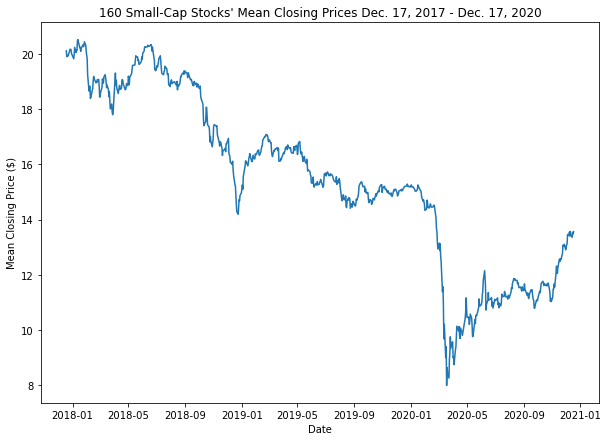

In [20]:
# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()

# Assigning x and y variables so they can be graphed
x = date_close_gb.keys()
y = date_close_gb.values

# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(x = x, y = y)
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "160 Small-Cap Stocks' Mean Closing Prices Dec. 17, 2017 - Dec. 17, 2020")
plt.show()

As shown in the plot above, the average closing price of small cap stocks has been in a downward trend since year-end 2017, falling sharply around March 2020 due to the Coronavirus pandemic and its economic impact, failing to fully recover by December 2020. The trend is much more negative than the overall market, which rose consistently until March 2020, where it fell but proceeded to exceed pre-Covid levels by December 2020. 

## Feature Engineering

In [21]:
def create_intra_clf_target(df_list):
    """
    Takes in list of dfs and creates target variable for each depending
    on if the closing price for each day exceeds the opening price. If the
    closing price exceeds the opening price, target = 1.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['intra_clf_target'] = 0
        for i in range(len(df)):
            
            if df['open'][i] < df['close'][i]:
                df['intra_clf_target'][i] = 1
            
            elif df['open'][i] > df['close'][i]:
                df['intra_clf_target'][i] = 0
    
            elif df['open'][i] == df['close'][i]:
                df['intra_clf_target'][i] = 2
    
    return df_list

The first feature I engineered was my target variable. The target signifies whether a stock's closing price for one day exceeds its opening price. If this is the case, the target variable = 1. If the opposite is true, wherein the stock closes lower than it opened, the target variable = 0. If the closing and opening prices are exactly the same, the target variable = 2.

In [60]:
df_list = create_intra_clf_target(df_list)

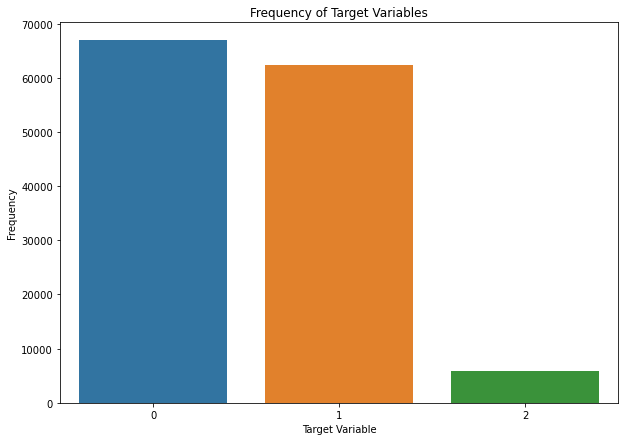

In [61]:
# Concatenating again after target variables have been created
df_joined_2 = pd.concat(df_list)

# Examining value counts of target variables
target_counts = df_joined_2['intra_clf_target'].value_counts()

# Assigning x and y variables for barplot
x = target_counts.keys()
y = target_counts.values

# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(x = x, y = y)
ax.set(xlabel = 'Target Variable', 
       ylabel = 'Frequency', 
       title = "Frequency of Target Variables")
sns.barplot(x = x, y = y)
plt.show()

As shown in the barplot above, there are relatively equivalent amounts of positive and negative cases, but high imbalance when compared to the neither case. As a result, I will use F1-Score as my evaluation metric.

In [24]:
def create_moving_avs(df_list):
    """
    Takes in list of dfs, creates three different moving average 
    features - 10, 50, and 200 days.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['10_day_ma'] = df['close'].ewm(span = 10).mean()
        df['50_day_ma'] = df['close'].ewm(span = 50).mean()
        df['200_day_ma'] = df['close'].ewm(span = 200).mean()
     
    return df_list

I know that moving averages are important technical indicators for price movement, so the next features I created served to account for both long and short-term moving averages. I created features for a 10, 50, and 200 day moving average.

In [62]:
# Takes in list of dfs, creates three different moving average features - 10, 50, and 200 days.
df_list = create_moving_avs(df_list)

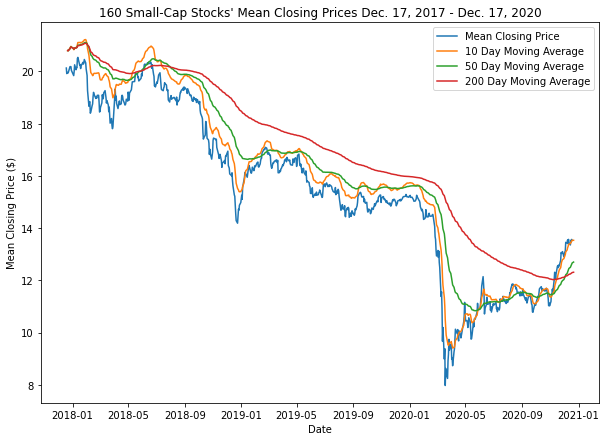

In [63]:
# Concatenating again after moving averages have been created
df_joined_3 = pd.concat(df_list)

# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()

ten_day_gb = df_joined_3.groupby(df_joined_3.index)['10_day_ma'].mean()
fifty_day_gb = df_joined_3.groupby(df_joined_3.index)['50_day_ma'].mean()
twohundred_day_gb = df_joined_3.groupby(df_joined_3.index)['200_day_ma'].mean()

# Assigning x1 and y1 to date and closing price
x1 = date_close_gb.keys()
y1 = date_close_gb.values

# Assigning x2 and y2 to the ten day moving average
x2 = ten_day_gb.keys()
y2 = ten_day_gb.values

# Assigning x3 and y3 to the fifty day moving average
x3 = fifty_day_gb.keys()
y3 = fifty_day_gb.values

# Assigning x4 and y4 to the two hundred day moving average
x4 = twohundred_day_gb.keys()
y4 = twohundred_day_gb.values


# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(x = x1, y = y1, label = 'Mean Closing Price')
sns.lineplot(x = x2, y = y2, label = '10 Day Moving Average')
sns.lineplot(x = x3, y = y3, label = '50 Day Moving Average')
sns.lineplot(x = x4, y = y4, label = '200 Day Moving Average')
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "160 Small-Cap Stocks' Mean Closing Prices Dec. 17, 2017 - Dec. 17, 2020")
plt.show()

The various moving averages are shown in comparison to the mean closing prices for each day. As one would expect, the 200 day average is much less affected by small price movements, as opposed to the 10 day average, which follows the mean closing price very closely.

An important concept in quantitative finance is <b>Mean Reversion</b>, which holds that stocks tend to revert to the moving average of their prices.

In [27]:
def create_pct_price_changes(df_list):
    """
    Takes in a list of dfs and creates price change (%) features with various
    intervals.
    Calculates % price changes relative to the day before observed date to 
    prediction using unknown data.
    
    df_list -- list of dfs
    """
    # Creating i_day_pct_change columns in each df
    for df in df_list:
        df['1_day_pct_change'] = 0
        df['2_day_pct_change'] = 0
        df['3_day_pct_change'] = 0
        df['4_day_pct_change'] = 0
   
        # Calculating ith day price change for each col
        for i in range(5, df.shape[0]):
            # Difference in closing prices between the previous day and the previous day
            diff = float(df['close'][i-1]) - float(df['close'][i-2])
            pct = (float(diff)/float(df['close'][i-2])) * 100
            df['1_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and two days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-3])
            pct = (float(diff)/float(df['close'][i-3])) * 100
            df['2_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and three days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-4])
            pct = (float(diff)/float(df['close'][i-4])) * 100
            df['3_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and four days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-5])
            pct = (float(diff)/float(df['close'][i-5])) * 100
            df['4_day_pct_change'][i] = pct
    
    return df_list

The following function creates price change (%) features with intervals ranging from one to four days for each df.
It calculates % price changes relative to the day before the observed date in order to avoid prediction using unknown data.

In [64]:
df_list = create_pct_price_changes(df_list)

In [29]:
def create_intra_clf_target(df_list):
    """
    Takes in list of dfs and creates target variable for each depending
    on if the closing price for each day exceeds the opening price. If the
    closing price exceeds the opening price, target = 1.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['intra_clf_target'] = 0
        for i in range(len(df)):
            
            if df['open'][i] < df['close'][i]:
                df['intra_clf_target'][i] = 1
            
            elif df['open'][i] > df['close'][i]:
                df['intra_clf_target'][i] = 0
    
            elif df['open'][i] == df['close'][i]:
                df['intra_clf_target'][i] = 2
    
    return df_list

In [65]:
df_list = create_intra_clf_target(df_list)

Below is an example of a dataframe with all features engineered:

In [31]:
df_list[0].head()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2017-12-18 06:00:00,19.45,19.80,19.200,19.30,156552,FRGI,0,19.300000,19.300000,19.300000,0,0,0,0
2017-12-19 06:00:00,19.25,19.55,19.200,19.35,126489,FRGI,1,19.327500,19.325500,19.325125,0,0,0,0
2017-12-20 06:00:00,19.50,19.60,18.950,19.05,149596,FRGI,0,19.215947,19.229969,19.232498,0,0,0,0
2017-12-21 06:00:00,19.15,19.40,18.900,19.30,207587,FRGI,1,19.243639,19.248541,19.249628,0,0,0,0
2017-12-22 06:00:00,19.35,19.40,19.025,19.25,254137,FRGI,0,19.245465,19.248857,19.249704,0,0,0,0


Note: The first five observed days contain no pct price change values. This is because there was no data before the first observed day, so all values begin on the fifth day. Below is a better representation:

In [32]:
df_list[0].tail()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2020-12-11 06:00:00,12.48,12.760,12.3100,12.42,97892,FRGI,0,12.574476,11.145809,9.654983,-3,-3,-2,-3
2020-12-14 06:00:00,12.43,12.635,11.9575,12.33,82460,FRGI,0,12.530026,11.192248,9.681615,-1,-4,-5,-3
2020-12-15 06:00:00,12.49,12.960,12.3000,12.62,90697,FRGI,1,12.546385,11.248238,9.710868,0,-2,-5,-5
2020-12-16 06:00:00,12.67,12.850,12.4400,12.52,116272,FRGI,0,12.541588,11.298111,9.738834,2,1,0,-3
2020-12-17 06:00:00,12.47,12.470,11.9400,12.07,192051,FRGI,0,12.455844,11.328381,9.762042,0,1,0,0


## Modleing and Results

### Initial Model

My baseline model was a KNN and was used to evaluate my engineered features. 

In [33]:
# Assign a test dataframe on which to evaluate
df_test = df_list[0]

# Split into train and test sets on February 2, 2020
train = df_test[:'2020-02-02']
test = df_test['2020-02-02':]

X_train, y_train = train[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], train['intra_clf_target']

X_test, y_test = test[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], test['intra_clf_target']

# Instantiate the KNN Classifier
knn = KNeighborsClassifier()

# Instantiate the scaler
scaler = StandardScaler()

# Fit, transform on the train set, only transform on the test set
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test data
preds = knn.predict(X_test)

# Evaluate metrics
print('Acc:', accuracy_score(y_test, preds)) # price changes improved to .486 from .45
print('Precision:', precision_score(y_test, preds, average = 'weighted')) # improved from .44 with price change featur

Acc: 0.4798206278026906
Precision: 0.4749015412184013


My initial accuracy and precision scores were .451 and .448, respectively; however, the addition of my moving average and percent-price-change features saw these increase to .486 and .481, respectively.

In [34]:
def time_cross_validate(df, model, param_grid):
    """
    Takes in df, model, and param_grid, and returns cross validated scores and params.
    
    df -- dataframe
    model -- model to be used for cross validation
    param_grid -- dictionary to be used for GridSearch param_grid
    """
    # Designating predictor and target columns
    predictor_cols = ['10_day_ma', 
                      '50_day_ma', 
                      '200_day_ma', 
                      '1_day_pct_change',
                      '2_day_pct_change', 
                      '3_day_pct_change', 
                      '4_day_pct_change']
    target = 'intra_clf_target'
    
    # Creating dataframe with numerical index that can be split
    dataframe = df.reset_index()

    # Creating tuples of train, test indices to be passed into the cv parameter of GridSearchCV
    train_test_indices_1 = (list(range(455)), list(range(455, 530)))
    train_test_indices_2 = (list(range(530)), list(range(530, 605)))
    train_test_indices_3 = (list(range(605)), list(range(605, 680)))
    train_test_indices_4 = (list(range(680)), list(range(680, 755)))
    
    # Splitting the df into data and target values
    data, target = dataframe[predictor_cols], df[target]
    
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit_transform(data)
    
    # Instantiating Gridsearch
    
    # add pipeline into 'estimator'
    clf = GridSearchCV(estimator = model,
                       param_grid = param_grid,
                       cv = [train_test_indices_1,
                             train_test_indices_2,
                             train_test_indices_3,
                             train_test_indices_4
                       ],
                       n_jobs = -1,
                       scoring = 'f1_weighted',
                       verbose = False
    )
    
    # Fitting Gridsearch
    clf.fit(data, target)
    
    # Get results and store them in a dictionary
    best_score = clf.best_score_
    best_params = clf.best_params_
    best_params['best_score'] = best_score
    
    return best_params

### Gridsearch and Cross Validation

Next I wanted to add another model - Random Forest - then gridsearch my parameters and cross validate my evaluation metric, F1-Score. I gridsearched only on the first ten dataframes in my list of dataframes for the sake of time. For each df and respective model fit to it, a dictionary with the parameters used in the model as well as the F1-Score attained with those parameters. For each model, I compile these into a list, then pick the parameters to use in my final models based on frequency.  

In [35]:
# Instantiate Random Forest and KNN Classifiers to be used in further modeling
rfc = RandomForestClassifier(random_state = 1)
knn = KNeighborsClassifier()

# Parameter grid for random forest gridsearch
rfc_param_grid = {'n_estimators': [500, 750, 1000],
                  'class_weight': ['balanced'],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [3, 5, 7]
             }

# Parameter grid for knn gridsearch
knn_param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                  'leaf_size': [15, 30, 40]
                 }

#### Random Forest

In [36]:
# Create a list of random forest best params and scores for first 10 dfs
rfc_gs_results = []

for df in df_list[:10]:
    # Gridsearch and Cross Validation 
    result = time_cross_validate(df = df, model = rfc, param_grid = rfc_param_grid)
    
    # Appending to list of dicts
    rfc_gs_results.append(result)            

In [37]:
rfc_gs_results

[{'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.5372476826150502},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.45255600701859716},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 500,
  'best_score': 0.4235570630114009},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 3,
  'n_estimators': 500,
  'best_score': 0.41214265446641224},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.46301788199337024},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 3,
  'n_estimators': 500,
  'best_score': 0.4865972608170165},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.44688561506892566},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_d

In [38]:
# Calculating mean random forest F1 score for the first 10 stocks
np.mean([x['best_score'] for x in rfc_gs_results])

0.4603205068467503

The highest performing parameters for the Random Forest based on this gridsearch are:
* max_depth = 7
* n_estimators = 1000
* criterion = 'gini'
* class_weight = 'balanced'

#### KNN

In [39]:
# Create a list of knn best params and scores for first 10 dfs
knn_gs_results = []

for df in df_list[:10]:
    # Gridsearch and Cross Validation
    result = time_cross_validate(df = df, model = knn, param_grid = knn_param_grid)
    
    # Appending to list of dicts
    knn_gs_results.append(result)            

In [40]:
knn_gs_results

[{'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.5561276934500141},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.47127110301113273},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.4826268020170537},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4791097562301946},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.43731365556018653},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.48427436030720233},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4645423782317034},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 6,
  'best_score': 0.44993615021796596},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4916804165690549},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4806952619214454}]

In [41]:
# Calculating mean KNN F1 score for the first 10 stocks
np.mean([x['best_score'] for x in knn_gs_results])

0.47975775775159535

The highest performing parameters for the KNN based on this gridsearch are:
* algorithm = 'auto'
* leaf_size = 15
* n_neighbors = 3

In [42]:
def time_train_test_split(df, split_date):
    """
    Takes in a df and a date to split train and test sets
    on the split date and returns X_train, X_test, y_train, y_test.
    Built to be incorporated with time_cross_validate().
    
    df -- dataframe of prices
    split_date -- str formatted as 'YYYY-MM-DD'
    """
    # Create list of split components
    train_test_sets = [] # not being used
    
    # Create train and test sets
    train = df[:split_date]
    test = df[split_date:]
    
    # Create list of columns to use in prediction, as well as target variable
    predictor_cols = ['10_day_ma', 
                      '50_day_ma', 
                      '200_day_ma', 
                      '1_day_pct_change',
                      '2_day_pct_change', 
                      '3_day_pct_change', 
                      '4_day_pct_change']
    target = 'intra_clf_target'
    
    # Create train and test sets
    X_train, X_test = train[predictor_cols], test[predictor_cols]
    y_train, y_test = train[target], test[target]
    
    return X_train, X_test, y_train, y_test

In [43]:
def scale_and_plant_random_forests(X_train, X_test, y_train, y_test):
    """
    Takes in train and test sets, runs a Random Forest Classifier on each,
    then returns a tuple of y test and y predicted values to be
    passed through an f1_score
    
    X_train -- training prediction data
    X_test -- testing prediction data
    y_train -- training target data
    y_test -- testing target data
    """
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit, transform on train set, only transform test set
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    # Instantiate Random Forest Classifier with gridsearched parameters
    rfc = RandomForestClassifier(random_state = 1,
                                 max_depth = 7,
                                 n_estimators = 1000,
                                 criterion = 'gini',
                                 class_weight = 'balanced'
                                )
    
    # Fit to the training data
    rfc.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = rfc.predict(X_test)
    
    return (y_test, y_pred)

In [44]:
def scale_and_knn(X_train, X_test, y_train, y_test):
    """
    Takes in train and test sets, runs a K Nearest Neighbors Classifier on each,
    then returns a tuple of y test and y predicted values to be
    passed through an f1_score.
    
    X_train -- training prediction data
    X_test -- testing prediction data
    y_train -- training target data
    y_test -- testing target data
    """
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit, transform on train set, only transform test set
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    # Instantiate K Neighbors Classifier with gridsearched parameters
    knn = KNeighborsClassifier(algorithm = 'auto',
                               leaf_size = 15, 
                               n_neighbors = 3
                              )
    
    # Fit to the training data
    knn.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = knn.predict(X_test)
    
    return (y_test, y_pred)

In [45]:
def compare_scores(df_list):
    """
    Takes in a list of dfs and returns a list of tuples to 
    compare the performance of two models based on their 
    respective F1 scores.
    
    df_list -- list of dfs
    """
    # Creating a list of tuples to compare model performance on each stock
    tuned_scores_comparison_list = []

    # Looping through the list of dfs
    for df in df_list:
        # Splitting train and test sets
        X_train, X_test, y_train, y_test = time_train_test_split(df, '2020-05-20')

        # Predicting with Random Forest
        (true, pred) = scale_and_plant_random_forests(X_train, X_test, y_train, y_test)

        # Evaluating Random Forest
        rfc_f1 = f1_score(true, pred, average = 'weighted')

        # Predicting with KNN
        (true, pred) = scale_and_knn(X_train, X_test, y_train, y_test)

        # Evaluating KNN
        knn_f1 = f1_score(true, pred, average = 'weighted')

        # Appending to list of tuples
        tuned_scores_comparison_list.append((rfc_f1, knn_f1))

    return tuned_scores_comparison_list

### Final Models

#### Analysis of Results and Comparing Models

For my final Random Forest and KNN models, I used the parameters I obtained through my gridsearch. I anticipated that there would not be a clear favorite among the two models, and that instead KNN would perform better on some stocks while Random Forest would perform better on others. I evaluated both models on the first ten stocks, creating a list of tuples of F1-Scores. The first item in each tuple corresponds to the Random Forest F1 and the second to the KNN F1.

In [46]:
# Creating a list of tuples to compare model performance on each stock
comparison_list = compare_scores(df_list[:10])
comparison_list

[(0.5305574523756341, 0.5405405405405406),
 (0.4664330997664331, 0.4628628628628629),
 (0.35089566310496545, 0.4510468392656331),
 (0.2582297937748175, 0.513736188549776),
 (0.3947006205070721, 0.41355584002642826),
 (0.5244998087583298, 0.48030540192702353),
 (0.46995209495209495, 0.4866641603493738),
 (0.3051480051480051, 0.44979318941583096),
 (0.5398688161846057, 0.5909989812428836),
 (0.4482323232323232, 0.45872621440803263)]

In [47]:
# Splitting the above tuples into individual lists of F1-Scores for the purpose of visualization
rfc_f1 = [x[0] for x in comparison_list]
knn_f1 = [x[1] for x in comparison_list]

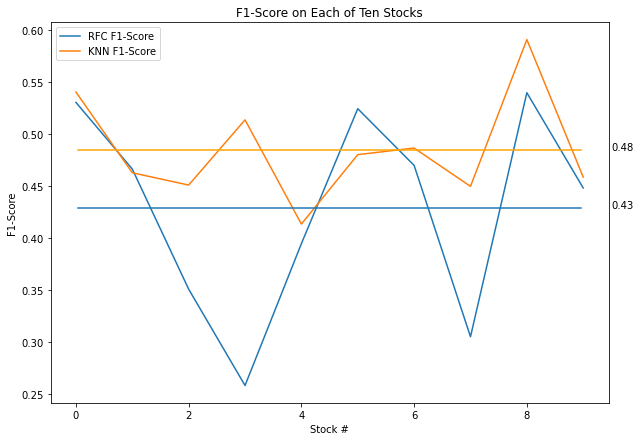

In [48]:
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(x = range(10), y = rfc_f1, label = 'RFC F1-Score')
sns.lineplot(x = range(10), y = knn_f1, label = 'KNN F1-Score')
ax.set(xlabel = 'Stock #',ylabel = 'F1-Score', title = 'F1-Score on Each of Ten Stocks')
ax.axhline(y = np.mean(rfc_f1), xmin = .05, xmax = .95)
ax.axhline(y = np.mean(knn_f1), xmin = .05, xmax = .95, color = 'orange')
ax.text(x = 9.5, y = np.mean(rfc_f1), s = str(round(np.mean(rfc_f1), 2)))
ax.text(x = 9.5, y = np.mean(knn_f1), s = str(round(np.mean(knn_f1), 2)))
ax.legend()
plt.show()

Contrary to my initial assumption, the KNN F1-Score (.48) outperformed the RF F1-Score (.43) by .05 on average, as shown in the graph above.

## Conclusion and Next Steps

The highest performing model was the KNN, though this is only on a sample of 10 out of 160. I'd like to predict on the entire set of 160, add additional models, and add an ensemble voting classifier.

In terms of next steps, I plan on implementing a regression model to predict exact prices in addition to price-movement-direction. To further improve the models I have, I'd like to add more features, such as momentum indicators like Moving Average Convergence/Divergence (MACD) and Relative Strength Index (RSI), as well as a volatility indicator like Standard Deviation or Beta. I'd also like to add a percent-change-in-volume feature.